In [1]:
#@title Imports. {display-mode:'form'}
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.layers import Input,Dense,GlobalAveragePooling2D,Flatten,concatenate,BatchNormalization, Dropout
from tensorflow.keras.applications import InceptionV3,DenseNet121
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K

# Visualize the Train/Val loss
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#@title Set the data generators. {display-mode:'form'}
shear_range = 0.1 #@param {type:"slider", min:0.0, max:1.0, step:0.05}
zoom_range = 0.1 #@param {type:"slider", min:0.0, max:1.0, step:0.05}
width_shift_range = 0.1 #@param {type:"slider", min:0.0, max:1.0, step:0.05}
height_shift_range = 0.1 #@param {type:"slider", min:0.0, max:1.0, step:0.05}
rotation_range = 10 #@param {type:"slider", min:0, max:90, step:5}
horizontal_flip = True #@param {type:"boolean"}
vertical_flip = False #@param {type:"boolean"}

train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=shear_range,
    zoom_range=zoom_range,
    width_shift_range=width_shift_range,
    height_shift_range=height_shift_range,
    rotation_range=rotation_range,
    horizontal_flip=horizontal_flip,
    vertical_flip=vertical_flip) 

train_generator=train_datagen.flow_from_directory('z:/Data/Parkinson_DATScans UKE/full_ppmi_data/png/all_2d_train', # this is where you specify the path to the main data folder
                                                 target_size=(109,91),
                                                 color_mode='rgb',
                                                 batch_size=64,
                                                 class_mode='categorical',
                                                 shuffle=True)

val_datagen=ImageDataGenerator(rescale=1./255) # No data augmentation here!

val_generator=val_datagen.flow_from_directory('z:/Data/Parkinson_DATScans UKE/full_ppmi_data/png/all_2d_val', # this is where you specify the path to the main data folder
                                                 target_size=(109,91),
                                                 color_mode='rgb',
                                                 batch_size=64,
                                                 class_mode='categorical',
                                                 shuffle=True)

test_datagen=ImageDataGenerator(rescale=1./255)

test_generator=test_datagen.flow_from_directory('z:/Data/Parkinson_DATScans UKE/Parkinson DAT UKE patients/Markus_Wenzel_UKE/png', # this is where you specify the path to the main data folder
                                                 target_size=(109,91),
                                                 color_mode='rgb',
                                                 batch_size=566,
                                                 class_mode='categorical',
                                                 shuffle=False) # don't shuffle so that the file names and indices are in sync.

Found 1097 images belonging to 2 classes.
Found 193 images belonging to 2 classes.
Found 566 images belonging to 2 classes.


In [10]:
#@title Set up the pretrained model, and add dense layers. {display-mode:'form'}

first_dense_layer_neurons  = 1024 #@param {type:"integer"}
second_dense_layer_neurons = 256 #@param {type:"integer"}
use_global_average_pooling = False #@param {type:"boolean"}
use_batch_norm             = True #@param {type:"boolean"}
use_drop_out               = False  #@param {type:"boolean"}
pretrained_model           = 'inception_v3' #|'densenet_121'

if pretrained_model == 'inception_v3':
    base_model=InceptionV3(weights='imagenet',include_top=False, input_shape=(109,91,3)) 
else:
    base_model=DenseNet121(weights='imagenet',include_top=False, input_shape=(109,91,3)) 

x=base_model.output

if use_global_average_pooling == True:
    x=GlobalAveragePooling2D()(x)
else:
    x=Flatten()(x)

if use_batch_norm:
    x = BatchNormalization()(x)
if use_drop_out:
    x = Dropout(rate=0.5)(x)
x = Dense(first_dense_layer_neurons,activation='relu')(x)

if use_batch_norm:
    x = BatchNormalization()(x)
if use_drop_out:
    x = Dropout(rate=0.5)(x)
x = Dense(second_dense_layer_neurons,activation='relu')(x)

if use_batch_norm:
    x = BatchNormalization()(x)
if use_drop_out:
    x = Dropout(rate=0.5)(x)
preds = Dense(2,activation='softmax')(x) # final layer with softmax activation

model=Model(inputs=base_model.input,outputs=preds)

In [11]:
#@title Set up the trainable parameters, fix the pretrained model for now. {display-mode:'form'}
optimizer = 'adam' #@param {type:'string'}
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
if optimizer in ['adam', 'adagrad', 'adadelta', 'sgd']: # standard settings
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics = ['accuracy']) # categorical crossentropy would also do...
else:
    from tensorflow.keras.optimizers import SGD
    model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='binary_crossentropy', metrics = ['accuracy'])

trainable_count = int(
    np.sum([K.count_params(p) for p in set(model.trainable_weights)]))
non_trainable_count = int(
    np.sum([K.count_params(p) for p in set(model.non_trainable_weights)]))

print('Total params: {:,}'.format(trainable_count + non_trainable_count))
print('Trainable params: {:,}'.format(trainable_count))
print('Non-trainable params: {:,}'.format(non_trainable_count))

Total params: 26,282,530
Trainable params: 4,468,994
Non-trainable params: 21,813,536


In [16]:
# train the model on the new data for a few epochs
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=train_generator.n//train_generator.batch_size,
                              epochs=100, # Originally, 500 epochs!
                             validation_data=val_generator,
                             validation_steps=val_generator.n//val_generator.batch_size)

Epoch 1/100
17/17 [==============================] - 3s 203ms/step - loss: 0.3473 - accuracy: 0.8470 - val_loss: 0.7877 - val_accuracy: 0.6771
Epoch 2/100
17/17 [==============================] - 3s 203ms/step - loss: 0.3263 - accuracy: 0.8567 - val_loss: 0.9800 - val_accuracy: 0.6771
Epoch 3/100
17/17 [==============================] - 3s 196ms/step - loss: 0.3027 - accuracy: 0.8683 - val_loss: 1.1083 - val_accuracy: 0.6771
Epoch 4/100
17/17 [==============================] - 3s 195ms/step - loss: 0.3101 - accuracy: 0.8596 - val_loss: 0.9690 - val_accuracy: 0.6719
Epoch 5/100
17/17 [==============================] - 4s 212ms/step - loss: 0.2974 - accuracy: 0.8667 - val_loss: 1.1028 - val_accuracy: 0.6771
Epoch 6/100
17/17 [==============================] - 3s 196ms/step - loss: 0.3295 - accuracy: 0.8650 - val_loss: 0.8966 - val_accuracy: 0.6667
Epoch 7/100
17/17 [==============================] - 3s 196ms/step - loss: 0.3394 - accuracy: 0.8519 - val_loss: 0.9759 - val_accuracy: 0.6250

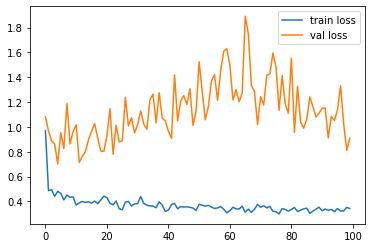

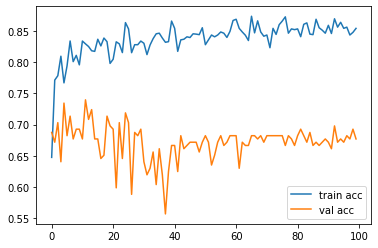

In [15]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

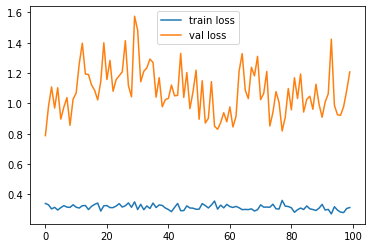

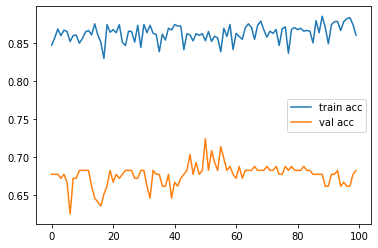

In [17]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

### TODO: Re-write to use MeVisLab test splits.

In [ ]:
model_metrics = model.evaluate_generator(test_generator, steps=1)
predictions = model.predict_generator(test_generator, steps=1)
preds = list(zip(predictions[:,0],predictions[:,1]))

print(model.metrics_names, model_metrics)

result = list(zip(test_generator.filenames, preds))
with open('results_InceptionV3_FC-layers_ppmiOnUKEall_300-128-1.txt', 'w') as f:
    f.write(repr(result))

In [ ]:
model_metrics = model.evaluate_generator(test_generator, steps=1)
predictions = model.predict_generator(test_generator, steps=1)
preds = list(zip(predictions[:,0],predictions[:,1]))

print(model.metrics_names, model_metrics)

result = list(zip(test_generator.filenames, preds))
with open('results_InceptionV3_FC-layers_ppmiOnUKEall_300-128-1.txt', 'w') as f:
    f.write(repr(result))

# Second experiment, fine-tuning the inception blocks

In [ ]:
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

In [ ]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

In [ ]:
# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
# from keras.optimizers import SGD
# model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
history_test = model.fit_generator(generator=train_generator,
                              steps_per_epoch=train_generator.n//train_generator.batch_size,
                              epochs=100,
                             validation_data=val_generator,
                             validation_steps=val_generator.n//val_generator.batch_size)

In [ ]:
plt.plot(history_test.history['loss'], label='train loss')
plt.plot(history_test.history['acc'], label='train acc')
plt.plot(history_test.history['val_loss'], label='val loss')
plt.plot(history_test.history['val_acc'], label='val acc')
plt.legend()
plt.show()

In [ ]:
model_metrics = model.evaluate_generator(test_generator, steps=1)
predictions = model.predict_generator(test_generator, steps=1)
preds = list(zip(predictions[:,0],predictions[:,1]))

print(model.metrics_names, model_metrics)

result = list(zip(test_generator.filenames, preds))
with open('results_InceptionV3_Inception-layers_ppmiOnUKEall_300-128-1.tx', 'w') as f:
    f.write(repr(result))